In [1]:
import os
import shutil

mount_point = '/content/drive'

# Check if the directory exists and is not empty
if os.path.isdir(mount_point) and os.listdir(mount_point):
    print(f"Clearing the mount point directory: {mount_point}")
    try:
        # Remove all contents of the directory
        for item in os.listdir(mount_point):
            item_path = os.path.join(mount_point, item)
            if os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        print("Mount point directory cleared.")
    except Exception as e:
        print(f"Error clearing mount point directory: {e}")
else:
    print(f"Mount point directory {mount_point} is already empty or does not exist.")

# Attempt to mount Google Drive again
from google.colab import drive
try:
    drive.mount(mount_point)
    print("Google Drive mounted successfully.")
except ValueError as e:
    print(f"Error mounting Google Drive: {e}")

Mount point directory /content/drive is already empty or does not exist.
Mounted at /content/drive
Google Drive mounted successfully.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import gc
gc.enable()

In [4]:
import os
import cv2
import numpy as np
import pathlib
import gc

base_classification_dir = pathlib.Path("/content/drive/MyDrive/pest_classifier/classification")

# Select only 5 categories for training
selected_category_names = [
    "rice leaf roller",
    "rice leaf caterpillar",
    "paddy stem maggot",
    "asiatic rice borer",
    "yellow rice borer"
]

directory_names = [str(i) for i in range(0, 102)]

train_dir = base_classification_dir / "train"
validation_dir = base_classification_dir / "val"
test_dir = base_classification_dir / "test"


print("\nDataset Paths Defined.")
print(f"Training data path: {train_dir}")
print(f"Validation data path: {validation_dir}")
print(f"Test data path: {test_dir}")


Dataset Paths Defined.
Training data path: /content/drive/MyDrive/pest_classifier/classification/train
Validation data path: /content/drive/MyDrive/pest_classifier/classification/val
Test data path: /content/drive/MyDrive/pest_classifier/classification/test


In [5]:
import psutil
print(f"Memory used: {psutil.virtual_memory().percent}%")


Memory used: 10.8%


In [6]:
import os

train_dir = "/content/drive/MyDrive/pest_classifier/classification/train"
folders = sorted(os.listdir(train_dir))
print("Folders found:", folders)
print("Total folders:", len(folders))


Folders found: ['0', '1', '10', '100', '101', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Total folders: 102


In [7]:
# Define image size and batch size
img_size = 224
batch_size = 32

print(f"Image size set to: {img_size}x{img_size}")
print(f"Batch size set to: {batch_size}")

Image size set to: 224x224
Batch size set to: 32


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
import os

# Function to count images in each category within a directory
def count_images_in_categories(directory, category_names):
    counts = {}
    full_directory_names = [str(i) for i in range(0, 102)]
    category_to_original_index = {name: full_directory_names.index(str(i)) for i, name in enumerate(selected_category_names)}

    for category_name in category_names:
        if category_name in category_to_original_index:
            original_index = category_to_original_index[category_name]
            category_dir = os.path.join(directory, str(original_index))
            if os.path.exists(category_dir):
                num_images = len([f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))])
                counts[category_name] = num_images
            else:
                counts[category_name] = 0 # Category directory not found
        else:
             counts[category_name] = 0 # Category name not in selected_category_names


    return counts

# Count images for each dataset
train_counts = count_images_in_categories(train_dir, selected_category_names)
val_counts = count_images_in_categories(validation_dir, selected_category_names)
test_counts = count_images_in_categories(test_dir, selected_category_names)

print("Image counts per category in Training set:")
print(train_counts)

print("\nImage counts per category in Validation set:")
print(val_counts)

print("\nImage counts per category in Test set:")
print(test_counts)

Image counts per category in Training set:
{'rice leaf roller': 669, 'rice leaf caterpillar': 292, 'paddy stem maggot': 156, 'asiatic rice borer': 631, 'yellow rice borer': 302}

Image counts per category in Validation set:
{'rice leaf roller': 111, 'rice leaf caterpillar': 48, 'paddy stem maggot': 26, 'asiatic rice borer': 106, 'yellow rice borer': 50}

Image counts per category in Test set:
{'rice leaf roller': 335, 'rice leaf caterpillar': 147, 'paddy stem maggot': 79, 'asiatic rice borer': 316, 'yellow rice borer': 152}


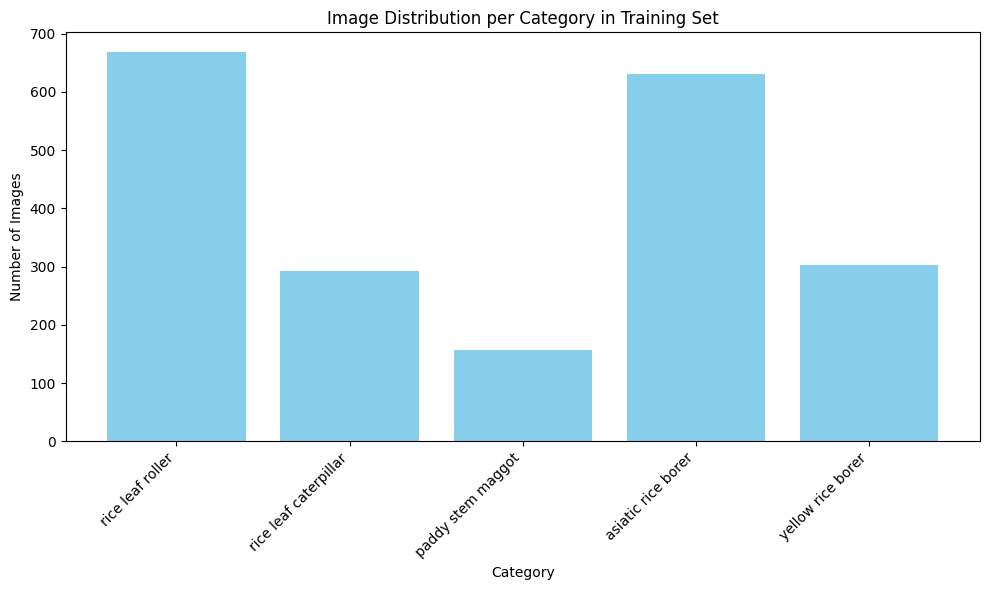

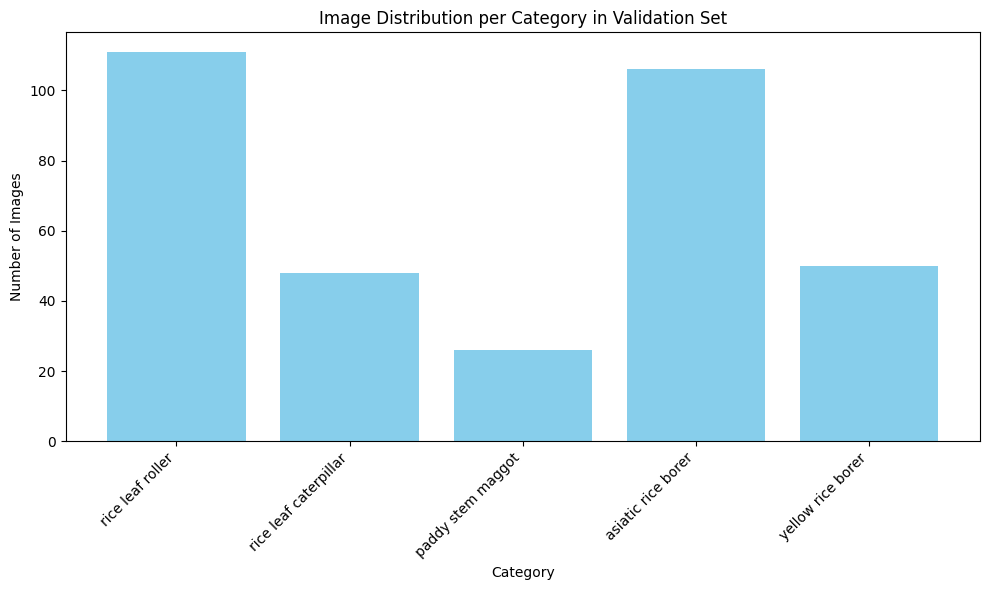

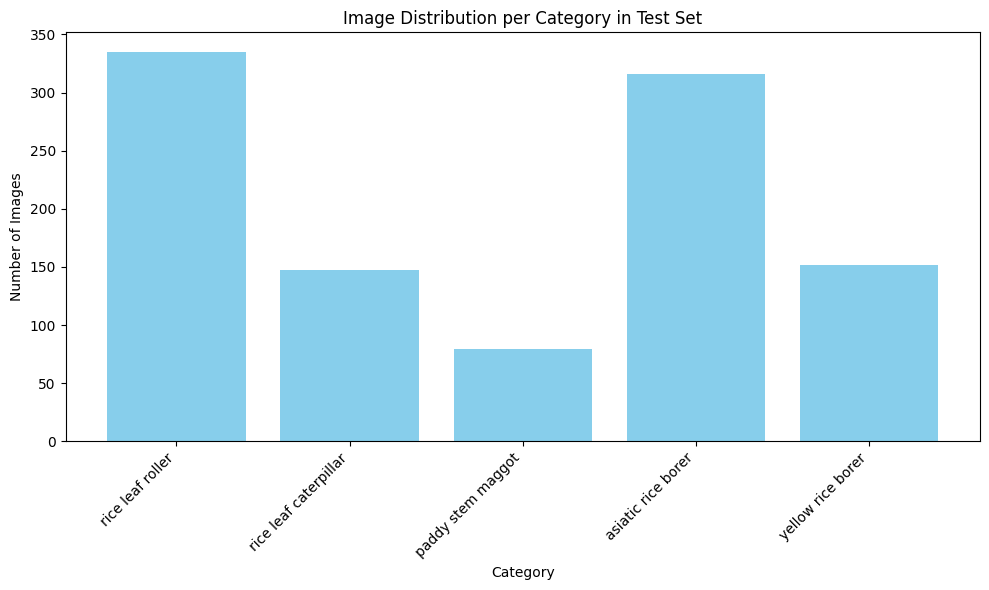

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_category_distribution(counts, dataset_name):
    """Plots a bar chart of image counts per category."""
    categories = list(counts.keys())
    image_counts = list(counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, image_counts, color='skyblue')
    plt.xlabel("Category")
    plt.ylabel("Number of Images")
    plt.title(f"Image Distribution per Category in {dataset_name} Set")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot distributions for each dataset
plot_category_distribution(train_counts, "Training")
plot_category_distribution(val_counts, "Validation")
plot_category_distribution(test_counts, "Test")

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness

# Define the data augmentation pipeline
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(factor=0.2),
], name="data_augmentation")

def load_and_preprocess_image(image_path, label, augment=False):
    """Loads and preprocesses an image, optionally applying augmentation."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = img / 255.0 # Normalize to [0, 1]
    if augment:
        img = data_augmentation(img, training=True) # Apply augmentation during training
    return img, label

def create_dataset(directory, category_names, shuffle=True, augment=False):
    """Creates a tf.data.Dataset from image files in a directory."""
    image_paths = []
    labels = []
    full_directory_names = [str(i) for i in range(0, 102)]
    category_to_original_index = {name: full_directory_names.index(str(i)) for i, name in enumerate(selected_category_names)}

    for i, category in enumerate(category_names):
        if category in category_to_original_index:
            original_index = category_to_original_index[category]
            category_dir = os.path.join(directory, str(original_index))
            if os.path.exists(category_dir):
                for img_name in os.listdir(category_dir):
                    image_paths.append(os.path.join(category_dir, img_name).encode('utf-8'))
                    labels.append(i)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    # Use lambda to pass the 'augment' parameter to load_and_preprocess_image
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Recreate the train_dataset with augmentation
train_dataset = create_dataset(train_dir, selected_category_names, augment=True)

# Recreate validation and test datasets without augmentation
val_dataset = create_dataset(validation_dir, selected_category_names, shuffle=False, augment=False)
test_dataset = create_dataset(test_dir, selected_category_names, shuffle=False, augment=False)

print("Data augmentation pipeline defined.")
print("tf.data.Dataset created/recreated with augmentation for training set.")
print("Validation and test datasets created/recreated without augmentation.")

Data augmentation pipeline defined.
tf.data.Dataset created/recreated with augmentation for training set.
Validation and test datasets created/recreated without augmentation.


In [ ]:
print("\nPlotting category distribution of the original training data (which is augmented on-the-fly during training):")
plot_category_distribution(train_counts, "Training (Augmented On-the-Fly)")

## Define resnet model

### Subtask:
Build a ResNet model using pre-trained weights (e.g., ResNet50, ResNet101) and add custom layers for your classification task.


**Reasoning**:
Build the ResNet model according to the instructions.



In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

base_resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers initially
for layer in base_resnet_model.layers:
    layer.trainable = False

x = base_resnet_model.output

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

# Update the output layer to have the number of selected categories
predictions = layers.Dense(len(selected_category_names), activation='softmax')(x)

resnet_model = models.Model(inputs=base_resnet_model.input, outputs=predictions)

fine_tune_at = len(base_resnet_model.layers) - 20 # Unfreeze the last 20 layers as a starting point

for layer in base_resnet_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])


print("\nResNet model modified for fine-tuning.")
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

ResNet model modified for fine-tuning.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 9,982,981 (38.08 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

## Define mobilenet model

### Subtask:
Build a MobileNet model using pre-trained weights (e.g., MobileNetV2) and add custom layers for your classification task.


**Reasoning**:
Build the MobileNetV2 model by loading pre-trained weights, freezing the base layers, and adding custom layers for classification, then print the model summary.



In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

base_mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_mobilenet_model.layers:
    layer.trainable = False


x = base_mobilenet_model.output

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

# Update the output layer to have the number of selected categories
predictions = layers.Dense(len(selected_category_names), activation='softmax')(x)


mobilenet_model = models.Model(inputs=base_mobilenet_model.input, outputs=predictions)


mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,916,421 (11.13 MB)

 Trainable params: 658,437 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Inception Net


**Reasoning**:
Build the InceptionV3 model by loading the pre-trained weights, adding custom layers, and printing the summary.



In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define image size
img_size = 224

base_inceptionv3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_inceptionv3_model.layers:
    layer.trainable = False

x = base_inceptionv3_model.output

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

# Update the output layer to have the number of selected categories
predictions = layers.Dense(len(selected_category_names), activation='softmax')(x)

inceptionv3_model = models.Model(inputs=base_inceptionv3_model.input, outputs=predictions)

inceptionv3_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,854,437 (87.18 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [17]:

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled.")

Mixed precision enabled.


## Define Callbacks

### Subtask:
Define ModelCheckpoint and EarlyStopping callbacks for model training.

**Reasoning**:
Define ModelCheckpoint callbacks to save the best weights for each model during training and an EarlyStopping callback to stop training when the validation accuracy stops improving.

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define ModelCheckpoint callbacks to save the best model weights
resnet_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_resnet_model.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

mobilenet_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_mobilenet_model.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

inceptionv3_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_inceptionv3_model.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='max', # Stop when validation accuracy is maximized
    restore_best_weights=True, # Restore model weights from the epoch with the best value
    verbose=1
)

print("ModelCheckpoint and EarlyStopping callbacks defined.")

ModelCheckpoint and EarlyStopping callbacks defined.


## Compile Models

### Subtask:
Compile the ResNet, MobileNetV2, and InceptionV3 models with appropriate optimizers, loss functions, and metrics.

**Reasoning**:
Compile each of the defined models using the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric.

In [19]:
from tensorflow.keras.optimizers import Adam

# Compile the ResNet model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), # Use the lower learning rate for fine-tuning
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Compile the MobileNetV2 model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Compile the InceptionV3 model
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

print("Models compiled successfully.")

Models compiled successfully.


In [20]:
print("\nTraining MobileNetV2 model...")
mobilenet_history = mobilenet_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[mobilenet_checkpoint_callback, early_stopping_callback]
)

tf.keras.backend.clear_session()
gc.collect()



Training MobileNetV2 model...
Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3729 - loss: 1.8788
Epoch 1: val_accuracy improved from -inf to 0.32551, saving model to /content/drive/MyDrive/best_mobilenet_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 350s 5s/step - accuracy: 0.3723 - loss: 1.8770 - val_accuracy: 0.3255 - val_loss: 2.1172
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3805 - loss: 1.5506
Epoch 2: val_accuracy did not improve from 0.32551
65/65 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.3801 - loss: 1.5506 - val_accuracy: 0.1466 - val_loss: 2.4131
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2455 - loss: 1.6046
Epoch 3: val_accuracy improved from 0.32551 to 0.33431, saving model to /content/drive/MyDrive/best_mobilenet_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.2462 - loss: 1.6039 - val_accuracy: 0.3343 - val_loss: 1.5472
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3423 - loss: 1.5429
Epoch 4: val_accuracy improved from 0.33431 to 0.34604, saving model to /content/drive/MyDrive/best_mobilenet_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.3424 - loss: 1.5430 - val_accuracy: 0.3460 - val_loss: 1.4845
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2128 - loss: 1.5573
Epoch 5: val_accuracy did not improve from 0.34604
65/65 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.2139 - loss: 1.5569 - val_accuracy: 0.3314 - val_loss: 1.5508
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2901 - loss: 1.5363
Epoch 6: val_accuracy did not improve from 0.34604
65/65 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.2903 - loss: 1.5362 - val_accuracy: 0.3460 - val_loss: 1.5643
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3161 - loss: 1.5131
Epoch 7: val_accuracy improved from 0.34604 to 0.35777, saving model to /content/drive/MyDrive/best_mobilenet_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.3164 - loss: 1.5131 - val_accuracy: 0.3578 - val_loss: 1.4949
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2391 - loss: 1.5595
Epoch 8: val_accuracy did not improve from 0.35777
65/65 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.2402 - loss: 1.5590 - val_accuracy: 0.3021 - val_loss: 1.5074
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2030 - loss: 1.5991
Epoch 9: val_accuracy did not improve from 0.35777
65/65 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2039 - loss: 1.5984 - val_accuracy: 0.3109 - val_loss: 1.6068
Epoch 10/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3126 - loss: 1.5530
Epoch 10: val_accuracy did not improve from 0.35777
65/65 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.3127 - loss: 1.5526 - val_accuracy: 0.1760 - val_loss: 1.6537
Restoring model weights from the end of the best epoch: 7.


0

In [21]:
mobilenet_model.evaluate(test_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.5530 - loss: 1.3544


[1.473242163658142, 0.34888240694999695]

In [22]:
mobilenet_model.evaluate(train_dataset)

65/65 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.2147 - loss: 1.5324


[1.4970293045043945, 0.3087804913520813]

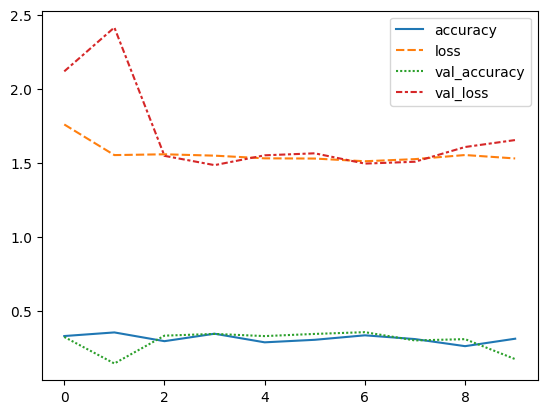

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(data=mobilenet_history.history)
plt.show()

In [24]:
gc.collect()

print("Training ResNet model...")
resnet_history = resnet_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[resnet_checkpoint_callback, early_stopping_callback]
)


tf.keras.backend.clear_session()
gc.collect()



Training ResNet model...
Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4134 - loss: 1.4817
Epoch 1: val_accuracy improved from -inf to 0.30499, saving model to /content/drive/MyDrive/best_resnet_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 583s 9s/step - accuracy: 0.4124 - loss: 1.4826 - val_accuracy: 0.3050 - val_loss: 1.5314
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3499 - loss: 1.5897
Epoch 2: val_accuracy did not improve from 0.30499
65/65 ━━━━━━━━━━━━━━━━━━━━ 558s 9s/step - accuracy: 0.3498 - loss: 1.5893 - val_accuracy: 0.3050 - val_loss: 1.5232
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3182 - loss: 1.5834
Epoch 3: val_accuracy improved from 0.30499 to 0.30792, saving model to /content/drive/MyDrive/best_resnet_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 553s 9s/step - accuracy: 0.3184 - loss: 1.5829 - val_accuracy: 0.3079 - val_loss: 1.4985
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3070 - loss: 1.5841
Epoch 4: val_accuracy did not improve from 0.30792
65/65 ━━━━━━━━━━━━━━━━━━━━ 554s 8s/step - accuracy: 0.3072 - loss: 1.5836 - val_accuracy: 0.3079 - val_loss: 1.5173
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3040 - loss: 1.5789
Epoch 5: val_accuracy improved from 0.30792 to 0.31085, saving model to /content/drive/MyDrive/best_resnet_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 567s 8s/step - accuracy: 0.3044 - loss: 1.5783 - val_accuracy: 0.3109 - val_loss: 1.5181
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2696 - loss: 1.5807
Epoch 6: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 525s 8s/step - accuracy: 0.2700 - loss: 1.5802 - val_accuracy: 0.3109 - val_loss: 1.4911
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2700 - loss: 1.5409
Epoch 7: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 588s 8s/step - accuracy: 0.2705 - loss: 1.5405 - val_accuracy: 0.3109 - val_loss: 1.4880
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3484 - loss: 1.5363
Epoch 8: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 561s 8s/step - accuracy: 0.3482 - loss: 1.5361 - val_accuracy: 0.3109 - val_loss: 1.4940
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2710 - loss: 1.5361
Epoch 9: val_accuracy did not improve from 0.31085


0

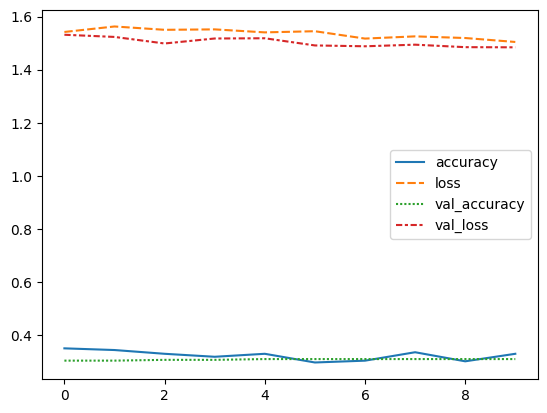

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(data=resnet_history.history)
plt.show()

In [26]:

print("\nTraining InceptionV3 model...")
inceptionv3_history = inceptionv3_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[inceptionv3_checkpoint_callback, early_stopping_callback]
)


Training InceptionV3 model...
Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3836 - loss: 5.4012
Epoch 1: val_accuracy improved from -inf to 0.26393, saving model to /content/drive/MyDrive/best_inceptionv3_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - accuracy: 0.3826 - loss: 5.3765 - val_accuracy: 0.2639 - val_loss: 1.6283
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2646 - loss: 1.5631
Epoch 2: val_accuracy improved from 0.26393 to 0.31085, saving model to /content/drive/MyDrive/best_inceptionv3_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 326s 5s/step - accuracy: 0.2651 - loss: 1.5630 - val_accuracy: 0.3109 - val_loss: 1.5404
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2594 - loss: 1.5765
Epoch 3: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 0.2600 - loss: 1.5763 - val_accuracy: 0.3109 - val_loss: 1.5873
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2464 - loss: 1.5871
Epoch 4: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 293s 4s/step - accuracy: 0.2472 - loss: 1.5867 - val_accuracy: 0.3109 - val_loss: 1.4950
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2540 - loss: 1.5456
Epoch 5: val_accuracy improved from 0.31085 to 0.32551, saving model to /content/drive/MyDrive/best_inceptionv3_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 299s 5s/step - accuracy: 0.2546 - loss: 1.5454 - val_accuracy: 0.3255 - val_loss: 1.4826
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3250 - loss: 1.5339
Epoch 6: val_accuracy did not improve from 0.32551
65/65 ━━━━━━━━━━━━━━━━━━━━ 297s 5s/step - accuracy: 0.3250 - loss: 1.5338 - val_accuracy: 0.3109 - val_loss: 1.5134
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3359 - loss: 1.5669
Epoch 7: val_accuracy did not improve from 0.32551
65/65 ━━━━━━━━━━━━━━━━━━━━ 297s 5s/step - accuracy: 0.3355 - loss: 1.5664 - val_accuracy: 0.3226 - val_loss: 1.5017
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3682 - loss: 1.5821
Epoch 8: val_accuracy did not improve from 0.32551
65/65 ━━━━━━━━━━━━━━━━━━━━ 296s 5s/step - accuracy: 0.3675 - loss: 1.5817 - val_accuracy: 0.3109 - val_loss: 1.4980
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3347 - loss: 1.5362
Epoch 9: val_accuracy did not improve from 0.32551


In [27]:
inceptionv3_train_results = inceptionv3_model.evaluate(train_dataset)

65/65 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.3133 - loss: 1.5322


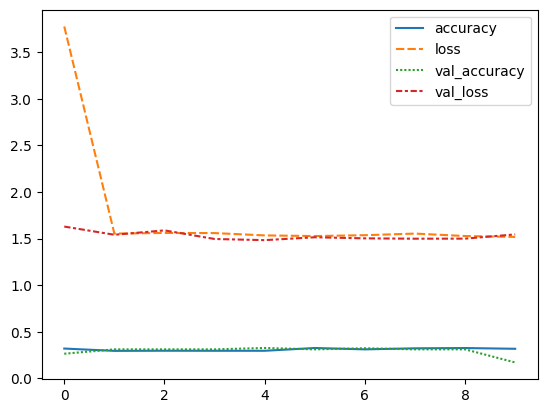

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(data=inceptionv3_history.history)
plt.show()

In [29]:
inceptionv3_test_results = inceptionv3_model.evaluate(test_dataset)

print(f"InceptionV3 Test Loss: {inceptionv3_test_results[0]:.4f}")
print(f"InceptionV3 Test Accuracy: {inceptionv3_test_results[1]:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.1604 - loss: 1.3883
InceptionV3 Test Loss: 1.4898
InceptionV3 Test Accuracy: 0.3100


## Define VGGNet model

Build a VGGNet model using pre-trained weights (e.g., VGG16, VGG19)

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

# Define VGG16 model
base_vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers initially
for layer in base_vgg_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_vgg_model.output
x = layers.Flatten()(x) # Flatten the output of the convolutional layers
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(selected_category_names), activation='softmax')(x)

vgg_model = models.Model(inputs=base_vgg_model.input, outputs=predictions)

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print("\nVGGNet model defined and compiled.")
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

VGGNet model defined and compiled.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Training VGGNet model...
Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.3424 - loss: 4.1214 
Epoch 1: val_accuracy improved from -inf to 0.32258, saving model to /content/drive/MyDrive/best_vgg_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 1353s 21s/step - accuracy: 0.3420 - loss: 4.1017 - val_accuracy: 0.3226 - val_loss: 1.5059
Epoch 2/10
 1/65 ━━━━━━━━━━━━━━━━━━━━ 35:53 34s/step - accuracy: 0.2812 - loss: 1.6788

KeyboardInterrupt: 

In [35]:
# prompt: train the vgg net model

import matplotlib.pyplot as plt
# Define ModelCheckpoint callback for VGGNet
vgg_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_vgg_model.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

print("\nTraining VGGNet model...")
vgg_history = vgg_model.fit(
    train_dataset,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=val_dataset,
    callbacks=[vgg_checkpoint_callback, early_stopping_callback]
)

# Evaluate the VGGNet model on the test set
vgg_test_results = vgg_model.evaluate(test_dataset)

print(f"VGGNet Test Loss: {vgg_test_results[0]:.4f}")
print(f"VGGNet Test Accuracy: {vgg_test_results[1]:.4f}")

# Plot training history
sns.lineplot(data=vgg_history.history)
plt.title("VGGNet Training History")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.show()

tf.keras.backend.clear_session()
gc.collect()


Training VGGNet model...
Epoch 1/10


KeyboardInterrupt: 


Generating Confusion Matrix for MobileNetV2:
33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step


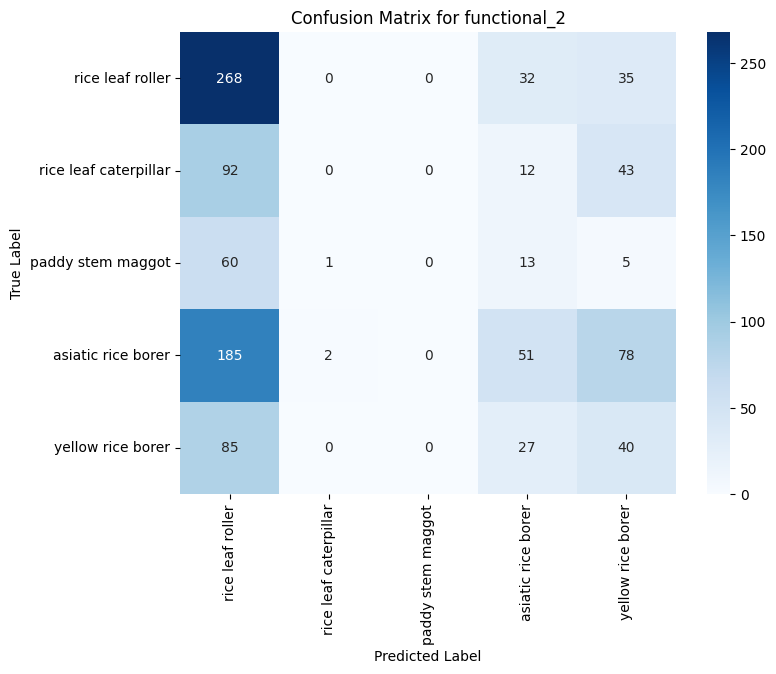


Generating Confusion Matrix for ResNet:
33/33 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step


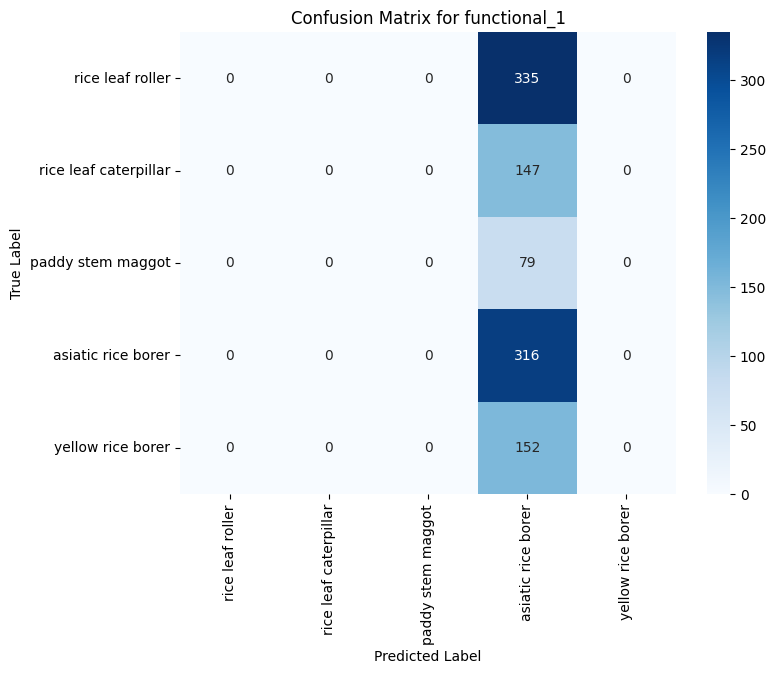


Generating Confusion Matrix for InceptionV3:
33/33 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step


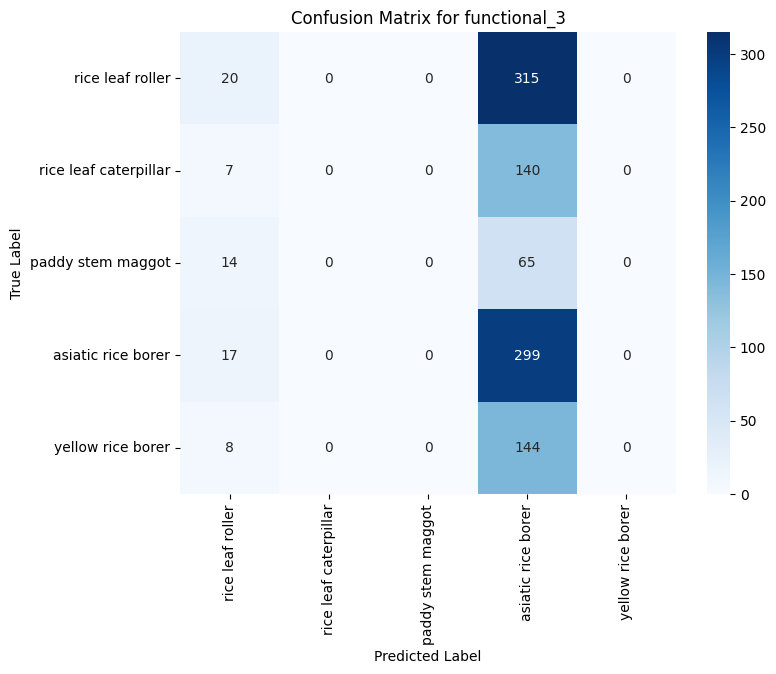


Generating Confusion Matrix for VGGNet:
20/33 ━━━━━━━━━━━━━━━━━━━━ 3:53 18s/step

KeyboardInterrupt: 

In [36]:
# prompt: generate heatmap for confusion matrices

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataset, class_names):
    """Generates and plots a heatmap for the confusion matrix."""

    # Get true labels from the dataset
    true_labels = []
    for images, labels in dataset.unbatch().as_numpy_iterator():
        true_labels.append(labels)
    true_labels = np.array(true_labels)

    # Get predicted labels
    predictions = model.predict(dataset)
    predicted_labels = np.argmax(predictions, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model.name}')
    plt.show()

# Example usage for each model:
print("\nGenerating Confusion Matrix for MobileNetV2:")
plot_confusion_matrix(mobilenet_model, test_dataset, selected_category_names)

print("\nGenerating Confusion Matrix for ResNet:")
plot_confusion_matrix(resnet_model, test_dataset, selected_category_names)

print("\nGenerating Confusion Matrix for InceptionV3:")
plot_confusion_matrix(inceptionv3_model, test_dataset, selected_category_names)

print("\nGenerating Confusion Matrix for VGGNet:")
plot_confusion_matrix(vgg_model, test_dataset, selected_category_names)


In [ ]:
# prompt: generate a model from scratch using conv2d, batchnorm, globalaveragepooling, make it efficient to maximize accuracy

import matplotlib.pyplot as plt
# Custom model from scratch
scratch_model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(len(selected_category_names), activation='softmax')
], name="scratch_model")

# Compile the model
scratch_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

print("\nCustom model from scratch defined and compiled.")
scratch_model.summary()

# Define ModelCheckpoint callback for the scratch model
scratch_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_scratch_model.weights.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

print("\nTraining custom model from scratch...")
scratch_history = scratch_model.fit(
    train_dataset,
    epochs=20,  # You might need more epochs for a model trained from scratch
    validation_data=val_dataset,
    callbacks=[scratch_checkpoint_callback, early_stopping_callback]
)

# Evaluate the scratch model on the test set
scratch_test_results = scratch_model.evaluate(test_dataset)

print(f"Custom Scratch Model Test Loss: {scratch_test_results[0]:.4f}")
print(f"Custom Scratch Model Test Accuracy: {scratch_test_results[1]:.4f}")

# Plot training history
sns.lineplot(data=scratch_history.history)
plt.title("Custom Scratch Model Training History")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.show()

tf.keras.backend.clear_session()
gc.collect()

print("\nGenerating Confusion Matrix for Custom Scratch Model:")
plot_confusion_matrix(scratch_model, test_dataset, selected_category_names)


Custom model from scratch defined and compiled.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "scratch_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,437 (1.75 MB)

 Trainable params: 456,965 (1.74 MB)

 Non-trainable params: 1,472 (5.75 KB)


Training custom model from scratch...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2077 - loss: 2.4606
Epoch 1: val_accuracy improved from -inf to 0.26979, saving model to /content/drive/MyDrive/best_scratch_model.weights.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 453s 7s/step - accuracy: 0.2077 - loss: 2.4585 - val_accuracy: 0.2698 - val_loss: 1.5954
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2355 - loss: 2.0558
Epoch 2: val_accuracy improved from 0.26979 to 0.32551, saving model to /content/drive/MyDrive/best_scratch_model.weights.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 509s 7s/step - accuracy: 0.2355 - loss: 2.0559 - val_accuracy: 0.3255 - val_loss: 1.5220
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2166 - loss: 2.0617
Epoch 3: val_accuracy improved from 0.32551 to 0.35191, saving model to /content/drive/MyDrive/best_scratch_model.weights.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 514s 7s/step - accuracy: 0.2169 - loss: 2.0605 - val_accuracy: 0.3519 - 